In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import random
from copy import deepcopy

In [43]:
df = pd.read_excel("15-Points.xlsx")

In [44]:
class Tour:
    def __init__(self, cities_list):
        self.fitness = 0
        self.cost = 0
        self.cities = cities_list
         
    def __repr__(self):
        return f"{self.cities}\nCost = {self.cost}"

In [45]:
class City:
    def __init__(self, n, x, y):
        self.name = n
        self.x_coor = x
        self.y_coor = y
        
    def __repr__(self):
        return f"{self.name}"

In [46]:
# Set random seed for reproducibility
np.random.seed(42)

### Read the data

In [47]:
def read_data(data):
    data_list = []
    m = data.shape[0]  
    for i in range(m):
        data_list.append(City(data['City'][i], data['x'][i], data['y'][i]))
        
    return data_list

In [48]:
def get_distance(city1, city2):
    x = city1.x_coor - city2.x_coor
    y = city1.y_coor - city2.y_coor
    distance = np.sqrt((x ** 2) + (y ** 2))
    return distance

In [49]:
def distance_matrix(tour):
    m = len(tour)
    matrix = np.zeros ((m, m))
    for i in range(m):
        for j in range(m):
            matrix[i][j] = get_distance(tour[i], tour[j])
            
    return matrix

In [50]:
def get_tour_cost(tour, dist_matrix):
#     print("***** Get Tour Cost *****")
    cost = 0
    for i in range(len(tour.cities)-1):
        city1 = tour.cities[i]
        city2 = tour.cities[i+1]
        cost += dist_matrix[(city1.name)-1, (city2.name)-1] # indicies
    # cost of returning back to the starting point
    cost += get_distance(tour.cities[-1], tour.cities[0])

    return cost

In [51]:
def get_tour_fitness(tour, dist_matrix):
#     print("***** Get Tour Fitness *****")
    fitness = 1/get_tour_cost(tour, dist_matrix)
    return fitness

In [52]:
def initialize_population(data_lst, pop_size, dist_matrix):
#     print("***** Initial Population *****")
    population = []
    for i in range(pop_size):
        tour = Tour(list(np.random.permutation(data_lst)))
        tour.cost = get_tour_cost(tour, dist_matrix)
        tour.fitness = get_tour_fitness(tour, dist_matrix)
        population.append(tour)
        
    return population

In [53]:
def elitism(population, elite_num):
#     print("***** Elitism Selection *****")
    sorted_pop = sorted(population, key=lambda tour: tour.fitness, reverse=True)
    return sorted_pop[:elite_num]

In [54]:
def tournament_selection(pop):
    candidates = random.choices(pop, k=5)
#     print("***** Tournament Selection *****")
    return max(candidates, key = lambda x: x.fitness)

In [55]:
def PMC_crossover(parent1, parent2, distance_matrix):
    crossover_point = random.choices(range(len(parent1.cities)), k=2)
    r1 = min(crossover_point)
    r2 = max(crossover_point)
    
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(r1, r2):
        temp1 = parent2.cities[i]
        temp2 = parent1.cities[i]
        
        indx1 = [c.name for c in child1.cities].index(temp1.name)
        indx2 = [c.name for c in child2.cities].index(temp2.name)
        
        child1.cities[indx1] = child1.cities[i]   
        child2.cities[indx2] = child2.cities[i]
        
        child1.cities[i] = temp1
        child2.cities[i] = temp2
       
    child1.cost = get_tour_cost(child1, distance_matrix)
    child2.cost = get_tour_cost(child2, distance_matrix)

    child1.fitness = 1/child1.cost
    child2.fitness = 1/child2.cost
    
    return child1, child2

In [56]:
def crossover(pop_size, crossover_prob, oldpop, distance_matrix):
#     print("***** Crossover *****")
    new_pop = []
    while True:
        parent1 = tournament_selection(oldpop)
        parent2 = tournament_selection(oldpop)
        rand_num = random.uniform(0,1)

        # apply partial crossover
        if rand_num < crossover_prob:
            child1, child2 = PMC_crossover(parent1, parent2, distance_matrix)   

            new_pop.append(child1)
            new_pop.append(child2)

        else:
            new_pop.append(parent1)
            new_pop.append(parent2)
            
        if len(new_pop) == pop_size:
            return new_pop

In [57]:
def tour_mutation(tour):
#     print("***** Tour Mutation *****")
    tour_length = len(tour.cities)
    swap_points = np.random.choice(np.arange(0, tour_length), size= 2, replace=False)
    c1, c2 = min(swap_points), max(swap_points)
    # swap cities then return the route again
    tour.cities[c1], tour.cities[c2] = tour.cities[c2], tour.cities[c1]
    return tour

In [58]:
def mutation(pop_size, pop, elite_num, mutation_prob, dist_matrix):
#     print("***** Mutation *****")
    mutation_size = mutation_prob * pop_size
    rand_tours = np.random.choice(np.arange(elite_num, pop_size), size = round(mutation_size), replace=False)
    rand_num = random.uniform(0,1)
#     if rand_num < mutation_prob:
    for tour in rand_tours:
        pop[tour] = tour_mutation(pop[tour])
        pop[tour].cost = get_tour_cost(pop[tour], dist_matrix)
        pop[tour].fitness = 1 / pop[tour].cost

    return pop

In [59]:
def Gene_Algo(pop_size, oldpop, num_elite, mutation_prob, crossover_prob, distance_matrix):
    newpop = []

    elites = elitism(oldpop, num_elite)
    newpop.extend(elites)

    newpop = crossover(pop_size, crossover_prob, oldpop, distance_matrix)
    newpop = mutation(pop_size, newpop, num_elite, mutation_prob, distance_matrix)

    return newpop

In [60]:
def algorithm(data):
    # initialize parameters
    mutation_prob = 0.1
    crossover_prob = 0.6
    population_size = 50
    num_elite = 2
    num_generations = 100
    
    lst = read_data(data)
    dist_matrix = distance_matrix(lst)
    population = initialize_population(lst, population_size, dist_matrix)
    
    for i in range (num_generations):   
        population = Gene_Algo(population_size, population, num_elite, mutation_prob, crossover_prob, dist_matrix)
        population = elitism(population, num_elite)

    result = elitism(population, num_elite)[0]
    result.cities.append(result.cities[0])
    print("Final Cost:", result)
    return result

In [61]:
ans = algorithm(df)

Final Cost: [11, 1, 13, 2, 15, 9, 5, 7, 3, 12, 14, 10, 8, 6, 4, 11]
Cost = 284.38109040803323


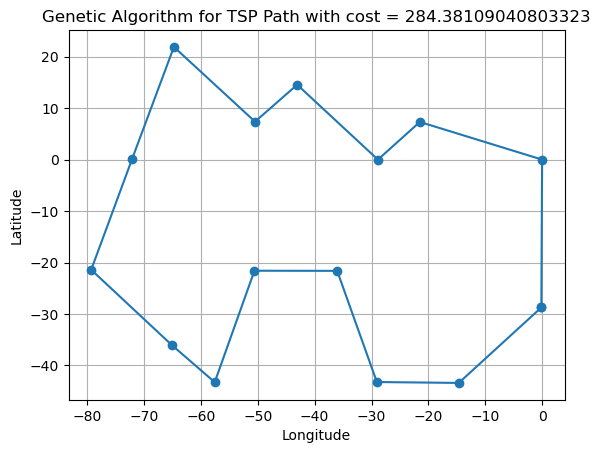

In [62]:
X = [city.x_coor  for city in ans.cities]
Y = [city.y_coor  for city in ans.cities]
plt.plot(X, Y, '-o')
plt.title(f'Genetic Algorithm for TSP Path with cost = {ans.cost}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()